# **ПРОЕКТ "Рекомендация тарифов"**

На основе данных о поведении клиентов, которые уже перешли на новые тарифы телеком-оператора требуется построить модель для задачи классификации, которая выберет подходящий тариф для других клиентов.

**Цель**: на основе данных о поведении клиентов оператора мобильной связи 'Мегалайн', уже перешедших на новые тарифы 'Smart' и 'Ultra', построить модель для классификации пользователей в зависимости от используемого ими тарифа.

**Целевое ограничение**: значение метрики accuracy должно быть **> 0.75**.

В результате проведенного исследования были выполнены следующие **задачи**:

 * изучен файл с данными
   
 * исходные данные разделены на обучающую, валидационную и тестовую выборки
    
 * исследовано качество разных моделей за счет изменения гиперпараметров
    
 * качество модели проверено на тестовой выборке
    
 * модель с наилучшим показателем accuracy проверена на адекватность с помощью DummyClassifier

Для выполнения проекта получены готовые данные: проводить предобработку и исследовательский анализ не требуется.

## **1 Общее знакомство с данными**

In [1]:
# загружаем необходимые библиотеки, структуры данных и функции

# основные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# подготовка к машинному обучению
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# модели машинного обучения
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# метрики машинного обучения
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

%matplotlib inline

# убираем 'красные' предупреждения
import warnings
warnings.filterwarnings("ignore")

In [2]:
# подгружаем файл с данными
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
    print('Dataset load from Practicum cloud')
except:
    from google.colab import drive
    drive.mount('/content/drive')
    path1 = '/content/drive/MyDrive/mydata/users_behavior.csv'
    df = pd.read_csv(path1)
    print('Dataset load from GoogleDrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset load from GoogleDrive


In [3]:
# посмотрим количество строк и столбцов в датасете
df.shape

(3214, 5)

In [4]:
# посмотрим первые пять строк файла
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Данные в датасете есть. Заголовки столбцов имеют корректный вид (но дополнительно проверим их специальной командой)

In [5]:
# посмотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Тип данных в столбце 'is_ultra' не булевый, а числовой ('int64'), но на достижение поставленной цели это не влияет. Менять тип данных в столбцах датасета не требуется

In [6]:
# проверим заголовки столбцов
df.columns

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

Названия заголовков столбцов корректные, изменения вносить не требуется

In [7]:
# посмотрим общие статистические данные
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


Поскольку во всех столбцах у данных числовой тип, есть возможность посмотреть статистические данные по всем столбцам датасета. Никаких проблем, требующих корректирующих действий, не обнаружено

In [8]:
# определяем количество пропусков в столбцах датасета
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

**Вывод по задаче 1**: изучение данных позволило установить, что датасет корректно заполнен, пропусков нет, названия столбцов соответствуют установленным требованиям. Датасет готов для построения модели для задачи классификации

## **2 Разделение данных на обучающую, валидационную и тестовую выборки**

Исходные данные необходимо разделить на **обучающую (60%)**, **валидационную (20%)** и **тестовую (20%)** выборки. Для этого сначала разделим датасет на обучающую выборку train_df (60%) и остальную часть датасета rest_data (40%), затем rest_data поделим пополам, получив валидационную (valid_df) и тестовую (test_df) выборки

Для достижения поставленной цели важно исключить вариант разбиения исходной выборки на подвыборки, между которыми будет нулевое или близкое к нему пересечение классовых меток. То есть на старте должно быть обеспечено наиболее оптимально возможное разделение данных. Для этого при объявлении функции train_test_split можно предусмотреть автоматическое перемешивание данных, для чего для параметра shuffle устанавливается значение False. В ходе проекта влияние параметра на распределение признаков классов было проверено, но в готовом решении его нет. Вот как выглядело распределение классов до применения параметра shuffle = False:

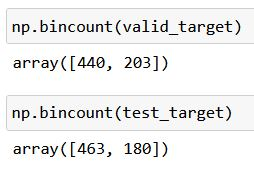

После применения параметра shuffle = False распределение признаков стало более равномерным (разница сократилась с 23 до 11):

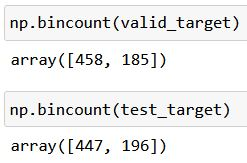

После применения параметра shuffle = False распределение признаков классов в целевых валидационной и тестовой выборках стало более равномерным. Было принято решение проверить, какой уровень распределения признаков классов будет достигнут при использовании параметра stratify. Результат значительно превзошел тот, который был получен при использовании параметра shuffle:

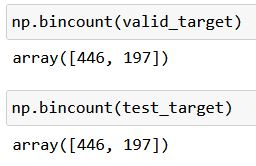

В итоговом отчете отсутствуют расчеты распределения классов до применения параметров, после применения параметра shuffle и после применения параметра stratify, сохранены только три принтскрина полученных результатов (выше). Важно отметить особенность 'взаимодействия' параметров shuffle и stratify: при одновременном указании параметров значение параметра shuffle = False не позволит выполнить код, значение параметра shuffle может быть только равным True

In [9]:
# разделяем выборку на обучающую (60%) и остальную (40%) части
df_train, df_rest = train_test_split(
    df,
    test_size = 0.4,
    random_state = 14,
    stratify = df.is_ultra)

In [10]:
# проверим размеры таблиц, чтобы оценить корректность разделения датасета
# на обучающую выборку и остальную часть
print(f'Тренировочная выборка: {(df_train.shape[0] / df.shape[0]):.0%}')
print(f'Остальная выборка: {(df_rest.shape[0] / df.shape[0]):.0%}')

Тренировочная выборка: 60%
Остальная выборка: 40%


In [11]:
# разделим оставшуюся часть выборки df_rest на валидационную и тестовую
df_valid, df_test = train_test_split(df_rest, test_size = 0.5,
    random_state = 14, stratify = df_rest.is_ultra)

In [12]:
# проверим размеры таблиц, чтобы оценить корректность разделения датасета
# на валидационную и тестовую выборки (они должны быть равны)
print(f'Валидационная выборка: {(df_valid.shape[0] / df_rest.shape[0]):.0%}')
print(f'Тестовая выборка: {(df_test.shape[0] / df_rest.shape[0]):.0%}')

Валидационная выборка: 50%
Тестовая выборка: 50%


По каждой из сформированных выборок объявим по две переменные, содержащие:

**(1)** признаки (всего четыре признака)

**(2)** целевой признак

Целевым признаком всех трех выборок будет столбец 'is_ultra' соответствующей выборки (один столбец). Переменная с признаками будет включать все остальные столбцы соответствующей выборки (четыре столбца)

In [13]:
# объявляем переменные с признаками и целевым признаком
# для тренировочной выборки df_train
train_features = df_train.drop(['is_ultra'], axis = 1)
train_target = df_train['is_ultra']

# проверим размеры переменных с признаками и целевым признаком
print('Обучающая выборка. Переменная с признаками:', train_features.shape)
print('Обучающая выборка. Переменная с целевым признаком:', train_target.shape)
print('')

# объявляем переменные с признаками и целевым признаком
# для валидационной выборки df_valid
valid_features = df_valid.drop(['is_ultra'], axis = 1)
valid_target = df_valid['is_ultra']

# проверим размеры переменных с признаками и целевым признаком
print('Валидационная выборка. Переменная с признаками:', valid_features.shape)
print('Валидационная выборка. Переменная с целевым признаком:',
      valid_target.shape)
print('')

# объявляем переменные с признаками и целевым признаком
# для тестовой выборки df_test
test_features = df_test.drop(['is_ultra'], axis = 1)
test_target = df_test['is_ultra']

# проверим размеры переменных с признаками и целевым признаком
print('Тестовая выборка. Переменная с признаками:', test_features.shape)
print('Тестовая выборка. Переменная с целевым признаком:',
      test_target.shape)

Обучающая выборка. Переменная с признаками: (1928, 4)
Обучающая выборка. Переменная с целевым признаком: (1928,)

Валидационная выборка. Переменная с признаками: (643, 4)
Валидационная выборка. Переменная с целевым признаком: (643,)

Тестовая выборка. Переменная с признаками: (643, 4)
Тестовая выборка. Переменная с целевым признаком: (643,)


**Вывод по задаче 2**: исходные данные разделены на обучающую (train_df), валидационную (valid_df) и тестовую (test_df) выборки. В соответствии со сложившейся традицией доля обучающей выборки в общем объеме данных составила 60%, валидационной - 20%, тестовой - 20%. Из каждой из трех выборок были выделены по две переменные: (1) переменная с признаками, (2) переменная с целевым признаком. В ходе исследования экспериментально было доказано превосходство параметра stratify над параметром shuffle в распределении признаков классов в полученных из первичного датасета выборках

## **3 Исследование моделей**

Для того, чтобы получить модель для классификации пользователей в зависимости от используемого ими тарифа предварительно необходимо создать несколько разных моделей и проверить, как будет меняться значение параметра accuracy в зависимости от установленных значений гиперпараметров

### **3.1 Модель классификации деревом решений (DecisionTreeClassifier)**

Для модели классификации деревом решений установим **гиперпараметры**:

**(1)** - **criterion = 'entropy'**. В качестве критерия также может быть указан коэффициент Джинни (**criterion = 'gini'**), однако изучение дополнительной литературы не позволило сделать вывод о принципиальном преобладании одного над другим. Так, на специализированных форумах отмечается, что коэффициенты Джини и энтропии практически одинаковы и могут использоваться взаимозаменяемо. В своем авторском курсе 'Основы Data Science и машинного обучения' Анатолий Карпов подробно разбирает критерий энтропии, лишь вскользь упоминая коэффициент Джини. Есть исследования, согласно которым применение критерия энтропии дает чуть лучший результат, чем применение критерия Джини, но требует больших вычислительных мощностей. При этом оба значения параметра **criterion** направлены на последовательное снижение неопределенности на каждом шаге обучения модели DecisiunTreeClassifier
   
   * Введение в Data Science и машинное обучение // Stepik. - URL: https://stepik.org/course/4852/promo
    
   * When should I use Gini Impurity as opposed to Information Gain (Entropy)? // StackExchange. - URL: https://datascience.stackexchange.com/questions/10228/when-should-i-use-gini-impurity-as-opposed-to-information-gain-entropy
   
   * Aznar, P. Decision Trees: Gini vs Entropy / P. Aznar // QuantDare. - URL: https://quantdare.com/decision-trees-gini-vs-entropy/
  
   * Decision Tree Learning and Impurity // StackOverFlow. - URL: https://stackoverflow.com/questions/4936788/decision-tree-learning-and-impurity
    
Критерий 'entropy' выбран по следующим причинам: его применение позволяет снизить уровень неопределенности при моделировании деревом решений. Датасет проекта не очень велик, поэтому более высокая энергоемкость не препятствует проведению исследования. Поэтому учет критерия энтропии повышает вероятность отнесения к одному из классов при решении задачи классификации, что более соответствует цели исследования - выявлению модели с наивысшим уровнем accuracy

**(2)** - **max_dept** - глубина дерева решений. Выбор глубины дерева решений представляет больший интерес при проведении эксперимента с деревом решений, так как это изменяемый параметр с потенциально неограниченным количеством вариантов. Однако, при слишком большом значении размера глубины дерева решений модель с большой вероятностью переобучится, при малом – недообучится. Заранее неизвестно, каким должен быть гиперпараметр max_depth, чтобы улучшить качество модели. Поэтому целесообразно перебрать в цикле разные значения max_depth и выбрать лучший вариант

**(3)** - **min_samples_split** - представляет собой минимальное количество выборок, необходимых для разделения **внутреннего узла**. Значение гиперпараметра может изменяться от одной выборки на каждом внутреннем узле до всех выборок на каждом внутреннем узле. Увеличение параметра замедляет процесс обучения дерева, так как с ростом min_samples_split все большее количество выборок должно учитываться на каждом внутреннем узле.

**(4)** - **min_samples_leaf** - это минимальное количество выборок, необходимое для разделения во **внешнем (конечном) узле**. Этот параметр аналогичен mine_samples_split, однако он описывает минимальное количество выборок на листьях дерева.

   * Ben Fraj, M. InDepth: Parameter tuning for Decision Tree / M. Ben Fraj // Medium - Where good ideas find you. - URL: https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

Чтобы разобраться в отличии гиперпараметра 'min_samples_split' от 'min_samples_leaf' следует провести различие между **листом** (также называемым **внешним (конечным) узлом** и **внутренним узлом**. Внутренний узел будет иметь дополнительные разбиения (также называемые **дочерними узлами**), в то время как лист по определению является узлом без каких-либо дочерних узлов (без каких-либо дальнейших разбиений), поэтому он характеризуется как **конечный (внешний)**. Соответственно, min_samples_split указывает минимальное количество выборок, необходимых для разделения внутреннего узла, в то время как min_samples_leaf указывает минимальное количество выборок, необходимых для конечного узла.

   * Difference between min_samples_split and min_samples_leaf in sklearn DecisionTreeClassifier // StackOverFlow. - URL: https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3
   
**(5)** - **max_features** - устанавливает максимальное количество признаков, которые учитываются при обучении модели, используется для контроля переобучения.  По сути это количество функций, которые необходимо учитывать каждый раз при принятии решения о 'ветвлении' модели. Например, размерность данных равна 50, а max_feature равен 10. Каждый раз, когда требуется принять решение о 'ветвлении' дерева, случайным образом выбираются 10 функций (признаков), которые используются, чтобы решить, какая из 10 функций является наилучшей для использования. Когда происходит переход к следующему узлу, случайным образом выбираются еще 10 функций (признаков) и так далее.

   * How max_features parameter works in DecisionTreeClassifier? // StackOverFlow. - URL: https://datascience.stackexchange.com/questions/41417/how-max-features-parameter-works-in-decisiontreeclassifier
   
Для гиперпараметров max_depth, min_samples_split, min_samples_leaf, max_features **будут установлены варьируемые значения**

Поиск лучшей модели классификации деревом решений **будет выполнен в двух вариантах**:

**(1)** вариант, совмещающий примеры решений из тренажера 'Яндекс.Практикума' и курса 'Введение в Data Science и машинное обучение' Анатолия Карпова на Stepik.ru

**(2)** выявление наилучших параметров с помощью GreedSearshCV

#### **3.1.1 Поиск лучшей модели классификации деревом решений по гиперпараметру max_depth**

Для выбора лучшей модели классификации деревом решений укажем в цикле гиперпараметр max_dept от 1 до 101 (100 разных значений гиперпараметра). Для каждого значения max_depth определим соответствующее ему значение accuracy и выясним, при каком значении max_depth доля правильных ответов accuracy будет наивысшей.

Дополнительно будет проведена оценка accuracy с использованием кроссвалидации. Кроссвалидация позволяет усреднять точность классификации и сравнивать дерево модели с разным параметром глубины дерева по усредненной точности на кроссвалидации. При определении параметра кроссвалидации обучающая выборка будет делиться на пять частей. Значение кроссвалидации для каждого гиперпараметра max_score будет усредняться. Оценка кроссвалидации будет проведена по обучающей выборке. С точки зрения документации scikit_lern для кроссвалидации выборка делится на тренировочную и тестовую, валидационная не выделяется. Однако, согласно техзадания должно быть выделено именно три выборки, поэтому оценка accuracy по кроссвалидации будет проведена по той же самой тренировочной выборке, по которой accuracy будет посчитано для тренировочной выборки и для валидационной выборки обычным способом

In [14]:
%%time

# создадим пустой датасет, в который будем добавлять значения accuracy
# по обучающей и валидационной выборке и по кроссвалидации
# по обучающей выборке
scores_model_1 = pd.DataFrame()

# с помощью цикла определим значения accuracy для тренировочной,
# валидационной выборки и для кроссвалидации по обучающей выборке
best_model_1 = None
best_result_model_1 = 0

for depth in tqdm(range(1, 101)):
    model_1 = DecisionTreeClassifier(
        random_state=14,
        criterion = 'entropy',
        max_depth = depth)
    model_1.fit(train_features, train_target)
    train_score = model_1.score(train_features, train_target)
    valid_score = model_1.score(valid_features, valid_target)
    mean_cross_val_score = cross_val_score(model_1,
        train_features, train_target, cv = 5).mean()
    temp_score_model_1 = pd.DataFrame({
        'max_depth': [depth],
        'train_score': [train_score],
        'valid_score': [valid_score],
        'cross_val_score': [mean_cross_val_score]})
    scores_model_1 = scores_model_1.append(temp_score_model_1)
    if mean_cross_val_score > best_result_model_1:
        best_model_1 = model_1
        best_result_model_1 = mean_cross_val_score

print('accuracy наилучшей модели по кроссвалидации на тренировочной выборке',
     best_result_model_1)

  0%|          | 0/100 [00:00<?, ?it/s]

accuracy наилучшей модели по кроссвалидации на тренировочной выборке 0.797709440818249
CPU times: user 8.37 s, sys: 55.3 ms, total: 8.42 s
Wall time: 8.76 s


In [15]:
# посмотрим, какие гиперпараметры есть у лучшей модели,
# сохраненной в переменной best_model_1
best_model_1

DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=14)

Далее полученные и сохраненные в датасет scores_model_1 значения accuracy будут визуализированы

In [16]:
# выведем первые пять строк датасета scores_model_1
scores_model_1.head()

,max_depth,train_score,valid_score,cross_val_score
0,1,0.756224,0.732504,0.755704
0,2,0.787344,0.766719,0.783195
0,3,0.800311,0.783826,0.793567
0,4,0.803942,0.780715,0.790457
0,5,0.815353,0.766719,0.790970


In [17]:
# с помощью метода melt() изменим формат представления данных в score_model_1,
# чтобы визуализировать результаты значений accuracy, полученные на обучающей
# и валидационной выборке
scores_model_1 = pd.melt(scores_model_1,
    id_vars = ['max_depth'],
    value_vars = ['train_score', 'valid_score', 'cross_val_score'],
    var_name = 'train_test_type',
    value_name = 'score')

scores_model_1.head()

,max_depth,train_test_type,score
0,1,train_score,0.756224
1,2,train_score,0.787344
2,3,train_score,0.800311
3,4,train_score,0.803942
4,5,train_score,0.815353


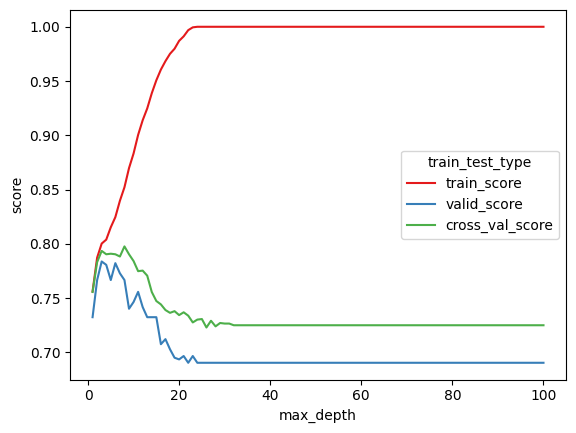

In [18]:
# визуализируем полученные данные значений accuracy для обучающей,
# валидационной выборки и кроссвалидации по обучающей выборке
sns.lineplot(data = scores_model_1,
    x = 'max_depth',
    y = 'score',
    hue = 'train_test_type',
    palette = 'Set1')

sns.set(rc={'figure.figsize': (15, 7)})

plt.show()

По графику мы видим, что наиболее оптимальная обученность модели была на уровне max_depth примерно на уровне от 7 до 8, - это следует из анализа динамики accuracy, полученных по валидационной выборке и по оценке кроссвалидации. Accuracy на тренировочной выборке достигает пика примерно на уровне max_dept = 17, но уже с уровня max_depth = 8 accuracy по валидационной выборке и по кроссвалидации быстро снижается: модель после max_depth = 8 начала переобучаться, увеличение глубины дерева после max_dept = 8 для рассматриваемой ситуации не имеет смысла.

Среднее значение accuracy по кроссвалидации во всех случаях из 100 значений параметра max_depth превосходит значение accuracy по валидационной выборке. Оценка по кроссвалидации является более точной. Значение параметра max_depth, при котором наблюдается наилучший результат модели, будет определен по кроссвалидации, поскольку точность оценки accuracy по кроссвалидации выше.

Чтобы определить гиперпараметр лучшей модели по наибольшему значению accuracy по кроссвалидации отфильтруем из датасета score_model_1 строки со значением типа оценки 'cross_val_score'. Для выбора наибольшего значения accuracy достаточно вывести первые 10 значений, так как лучшее значение, судя по графику, пришлось на max_depth равное 7 или 8

In [19]:
scores_model_1.query('train_test_type == "cross_val_score"').head(10)

,max_depth,train_test_type,score
200,1,cross_val_score,0.755704
201,2,cross_val_score,0.783195
202,3,cross_val_score,0.793567
203,4,cross_val_score,0.790457
204,5,cross_val_score,0.790970
205,6,cross_val_score,0.790456
206,7,cross_val_score,0.788388
207,8,cross_val_score,0.797709
208,9,cross_val_score,0.790460
209,10,cross_val_score,0.784229


Наилучшее значение accuracy = 0.7977 для модели классификации деревом решений достигнуто при гиперпараметре max_depth = 8

**Вывод по 3.1.1**:

**(1)** наилучшее значение accuracy = 0.7977 для модели классификации деревом решений достигнуто при гиперпараметре max_depth = 8

**(2)** техзаданию, согласно которому accuracy >= 0.75, модель соответствует. Модель сохранена в переменную **best_model_1**

#### **3.1.2 Поиск лучшей модели классификации деревом решений с помощью GridSearchCV**

In [20]:
# объявим модель классификации деревом решений
model_best_1 = DecisionTreeClassifier(random_state = 14)

Несмотря на то, что во введении к п. 3.1 было подробно обосновано применение гиперпараметра 'criterion' равным 'entropy', дополнительно проверим, какое значение гиперпараметра - 'entropy' или 'gini', - позволяет лучше обучить модель с использованием инструмента GridSearchCV

In [21]:
# создаем словарь с гиперпараметрами и варьируемыми значениями
params_model_best_1 = {'max_depth': range(1, 21),
                       'min_samples_split': range(1, 11),
                       'min_samples_leaf': range(1, 11),
                       'max_features': range(1, 11),
                       'criterion': ['entropy', 'gini']}

In [22]:
%%time

# объявляем объект GridSearchCV
grid_model_best_1 = GridSearchCV(model_best_1, params_model_best_1, cv = 5)

# обучаем модель с помощью функции fit()
grid_model_best_1.fit(train_features, train_target)

CPU times: user 24min 28s, sys: 4.64 s, total: 24min 33s
Wall time: 24min 41s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=14),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 21),
                         'max_features': range(1, 11),
                         'min_samples_leaf': range(1, 11),
                         'min_samples_split': range(1, 11)})

In [23]:
# сохраним модель DecisionTreeClassifier, полученную с помощью
# GreedSearchCV, в переменную best_tree_model
best_tree_model = grid_model_best_1.best_estimator_
best_tree_model

DecisionTreeClassifier(max_depth=8, max_features=4, min_samples_leaf=4,
                       min_samples_split=10, random_state=14)

Посчитаем accuracy. Значение accuracy в GridSearchCV определяется с помощью кроссвалидации. В п. 1.3.1 лучшее значение также было взято по кроссвалидации, обучающие выборки совпадают, поэтому сравнение показателя будет корректным

In [24]:
# вычислим accuracy по кроссвалидации модели с лучшими параметрами
grid_model_best_1.best_score_

0.8070506695377162

Лучшее значение accuracy, определенное только по преребору одного параметра max_depth, составило 0.7977. Применение GreedSearchCV и поиск модели с лушими хаарктеристиками уже по четырем вариативным параметрам позволили получить accuracy 0.8070 (на 0.0093 выше).

In [25]:
# посмотрим на выявленные с помощью GridSearchCV
# лучшие значения гиперпараметров
grid_model_best_1.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 10}

Визуализируем лучшую модель классификации деревом решений (сохранена в переменной best_tree_model)

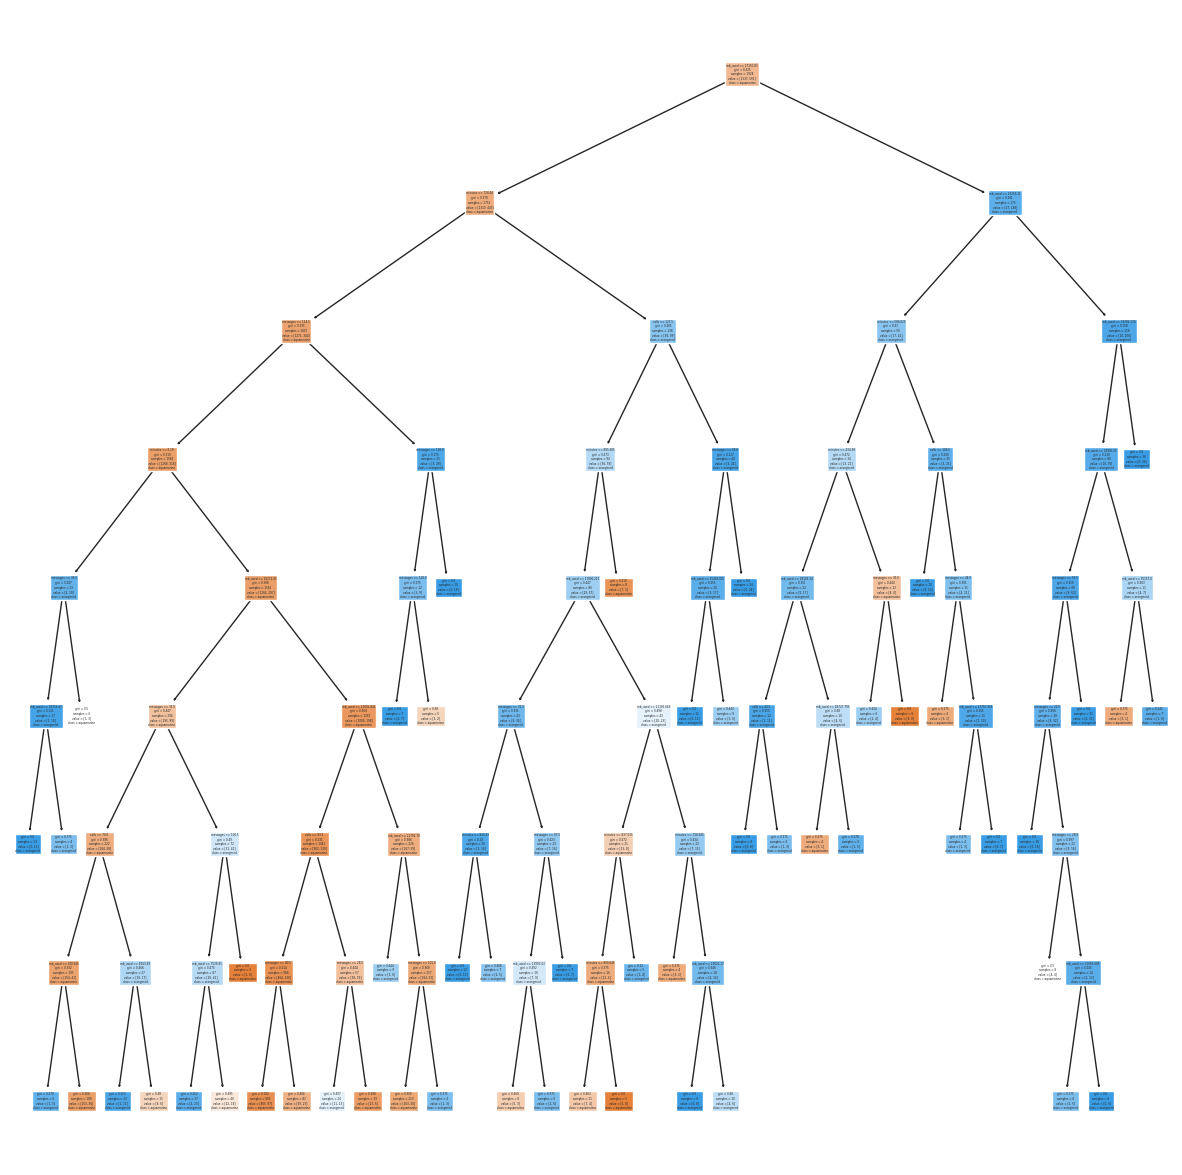

In [26]:
# с помощью plot_tree визуализируем лучшую модель классификации деревом решений
fn = [
    'calls',
    'minutes',
    'messages',
    'mb_used'
]

cn = ['aquamarine', 'orangered', 'lime']
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 15))
plot_tree(best_tree_model,
         feature_names = fn,
         class_names = cn,
         filled = True)
plt.show()

В связи с тем, что глубина обучения достаточно велика (max_depth = 8), график, отображающий модель классификации деревом решений с наилучшими парамтерами не очень наглядный. Но как минимум мы убедились, что он есть, и в общих чертах можем ознакомиться с 'ходом мысли' обученной нами модели

**Вывод по 3.1.2**:

**(1)** наилучшее значение accuracy = 0.8070 для модели классификации деревом решений выявлено с помощью GridSearchCV при гиперпараметрах:

    - 'criterion': gini
    - 'max_depth': 8
    - 'max_features': 4
    - 'min_samples_leaf': 4
    - 'min_samples_split': 10
    
**(2)** техаданию, согласно которому accuracy >= 0.75 модель соответствует. Модель сохранена в переменную **best_tree_model**

**Вывод по 3.1  Модель классификации деревом решений (DecisionTreeClassifier)**:

**(1)** был проведен анализ, в результате которого выявлена модель DecisionTreeClassifier с наибольшим уровнем accuracy. Модель была определена с помощью GridSearchCV и при значениях гиперпараметров:

   'criterion' = 'entropy', 'max_depth' = 8, 'max_features' = 4, 'min_samples_leaf' = 4, 'min_samples_split' = 10
   
показала уровень accuracy = 0.8070

**(2)** Модель с лучшими параметрами сохранена в переменную **best_tree_model**

### **3.2 Модель классификации случайного леса (RandomForestClassifier)**

Для модели классификации случайного леса применимы те пять критериев, которые были подробно рассмотрены в п.3.1 для модели классификации деревом решений:
   - 'criterion'
   - 'max_depth'
   - 'max_features'
   - 'min_samples_split'
   - 'min_samples_leaf'

Для модели классификации случайного леса **дополнительно применим еще два гиперпараметра**
   
**(1)** основным гиперпараметром, отличающим модель классификации случайного леса от модели классификации деревом решений является **n_estimators** (от англ. number of estimators / количество оценщиков). Чем больше деревьев, тем длительнее время обучения модели, но выше точность, и наоборот. Проверим значение accuracy при значениях гиперпараметра n_estimators от 1 до 10.
   
При этом мы должны понимать, что добавление к ранее обозначенным параметрам еще одного существенно замедлит обучение модели. Поэтому вариантивные показатели будут скорректированы следующим образом:
   
   - для гиперпараметра 'criterion' оставим только одно значение 'entropy'. Даже несмотря на то, что эксперимент на модели классификации деревом решений показал, что лучшим является 'criterion' = 'gini'. Этот результат не является достаточно доказательным, а во введении к п. 3.1 подробно был обоснован выбор 'criterion' = 'entropy'
   
   - для гиперпараметра min_samples_leaf будут проверены значения в диапазоне range(1, 5)
   
   - для гиперпараметра max_features будут проверены значения в диапазоне range(1, 5)
   
**(2)** **n-jobs** - прямого отношения к качеству обучения модели не имеет, но значительно повышает скорость ее обучения. Это важно, поскольку для модели классификации случайного леса мы задаем еще больше гиперпараметров. Гиперпараметр определяет, сколько параллельных процессов или потоков следует использовать для подпрограмм, которые распараллеливаются с помощью joblib. Представляет собой целое число, указывающее максимальное количество одновременно работающих ядер процессора. При n_jobs = 1 распараллеливание не происходит вообще (все расчеты производятся только на одном ядре процессора). При n_jobs = -1 все ядра процессора вовлекаются в работу, и скорость обучения модели в зависимости от технических характеристик процессора (значительно) увеличивается.

   * Glossary of Common Terms and API Elements // scikit_lern: Machine Lerning in Python. - URL: https://scikit-learn.org/stable/glossary.html#term-n-jobs
   
Отметим, что, возможно, именно в рамках этого проекта применение параметра n_jobs не позволит ускорить обучение модели, т.к. проект выполнен в облачном сервисе, но при выполнении на локальном компьютере этот гиперпараметр обязателен и забывать о нем нельзя.

Аналогично п. 3.2.1 поиск лучшей модели классификации случайного леса **будет выполнен в двух вариантах**:

**(1)** первый вариант предполагает совмещение примеров решений из тренажера 'Яндекс.Практикума' и курса 'Введение в Data Science и машинное обучение' Анатолия Карпова на Stepik.ru. **Отличие будет состоять в том**, что поиск лучшей модели будет выполнен по двум варьируемым параметрам: 'max_depth' и 'n_estimators'

**(2)** второй вариант предполагает выявление наилучших гиперпараметров с помощью GreedSearshCV. Лучшая модель будет выявлена на основе перебора пяти вариативных гиперпараметров: 'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features'. Дополнительно будет включен гиперпараметр 'criterion' = 'entropy' и увеличивающий скорость обучения модели гиперпараметр 'n_jobs' = -1. Также при объявлении объекта GridSearchCV дополнительно будет установлен параметр 'scoring' = accuracy, чтобы модель классификации случайного леса была в первую очередь ориентирована на поиск оптимальной модели с самым высоким уровнем accuracy

#### **3.2.1 Поиск лучшей модели классификации случайного леса по гиперпараметрам n_estimators и max_depth**

Модель с лучшими уровнем обученности на тренировочной выборке будет выбрана по двум вариативным гиперпараметрам: количество деревьев 'n_estimators' = range(1, 11), максимальная глубина ветвления каждого дерева 'max_depth' = range(1, 31). Accuracy будет оцениваться по обучающей, валидационной выборке и по кроссвалидации на тренировочной выборке. Лучшая модель будет выбрана по максимальному значению accuracy по кроссвалидации

In [27]:
%%time

# создадим пустой датасет, в который будем добавлять значения accuracy
# по обучающей, валидационной выборкам и accuracy по кроссвалидации
# по обучающей выборке
scores_model_2 = pd.DataFrame()

# с помощью цикла определим значения accuracy для обучающей,
# валидационной выборки и для кроссвалидации по обучающей выборке
best_model_2 = None
best_result_model_2 = 0

for depth in range(1, 31):
    for est in range(1, 11):
        model_2 = RandomForestClassifier(
            random_state=14,
            criterion = 'entropy',
            max_depth = depth,
            n_estimators = est)
        model_2.fit(train_features, train_target)
        train_score_2 = model_2.score(train_features, train_target)
        valid_score_2 = model_2.score(valid_features, valid_target)
        mean_cross_val_score_2 = cross_val_score(model_2,
            train_features, train_target, cv = 5).mean()
        temp_score_model_2 = pd.DataFrame({
            'max_depth': [depth],
            'n_estimators': [est],
            'train_score': [train_score_2],
            'valid_score': [valid_score_2],
            'cross_val_score': [mean_cross_val_score_2]})
        scores_model_2 = scores_model_2.append(temp_score_model_2)
        if mean_cross_val_score_2 > best_result_model_2:
            best_model_2 = model_2
            best_result_model_2 = mean_cross_val_score_2

print('accuracy наилучшей модели по кроссвалидации на тренировочной выборке',
     best_result_model_2)

accuracy наилучшей модели по кроссвалидации на тренировочной выборке 0.8096494179395733
CPU times: user 45.4 s, sys: 138 ms, total: 45.6 s
Wall time: 45.8 s


In [28]:
# посмотрим, какие гиперпараметры есть у лучшей модели
best_model_2

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=9,
                       random_state=14)

Формально на этом моменте п. 3.2.1 **можно считать выполненным**: гиперпараметры лучшей модели определены; полученный уровень accuracy = 0.8096 соответствует установленному ограничению >= 0.75. Но **для расширения представления о динамике accuracy** построим линейный график, аналогичный графику из п. 3.1.1

In [29]:
# выведем первые пять строк датасета scores_model_2, включающего информацию
# о значениях accuracy для соответствующих значений гиперпараметров
scores_model_2.head()

,max_depth,n_estimators,train_score,valid_score,cross_val_score
0,1,1,0.756224,0.732504,0.748438
0,1,2,0.755187,0.734059,0.752595
0,1,3,0.756224,0.734059,0.751551
0,1,4,0.756224,0.732504,0.753632
0,1,5,0.756224,0.732504,0.750516


In [30]:
# с помощью метода melt() изменим формат представления данных в score_model_2,
# чтобы визуализировать результаты значений accuracy, полученные на обучающей
# и валидационной выборке
scores_model_2 = pd.melt(scores_model_2,
    id_vars = ['max_depth', 'n_estimators'],
    value_vars = ['train_score', 'valid_score', 'cross_val_score'],
    var_name = 'train_valid_cross_type',
    value_name = 'score')

scores_model_2.head()

,max_depth,n_estimators,train_valid_cross_type,score
0,1,1,train_score,0.756224
1,1,2,train_score,0.755187
2,1,3,train_score,0.756224
3,1,4,train_score,0.756224
4,1,5,train_score,0.756224


В отличие от п. 3.1.1 оценка accuracy была проведена не по одному, а по двум гиперпараметрам, но в параметре x = '' sns.lineplot может быть указан только один. Поэтому построим два графика:

   - **(1)** для x = 'max_depth'
   - **(2)** для x = 'n_estimators'
   
Строим график, отображающий динамику accuracy с параметром х = 'max_depth'

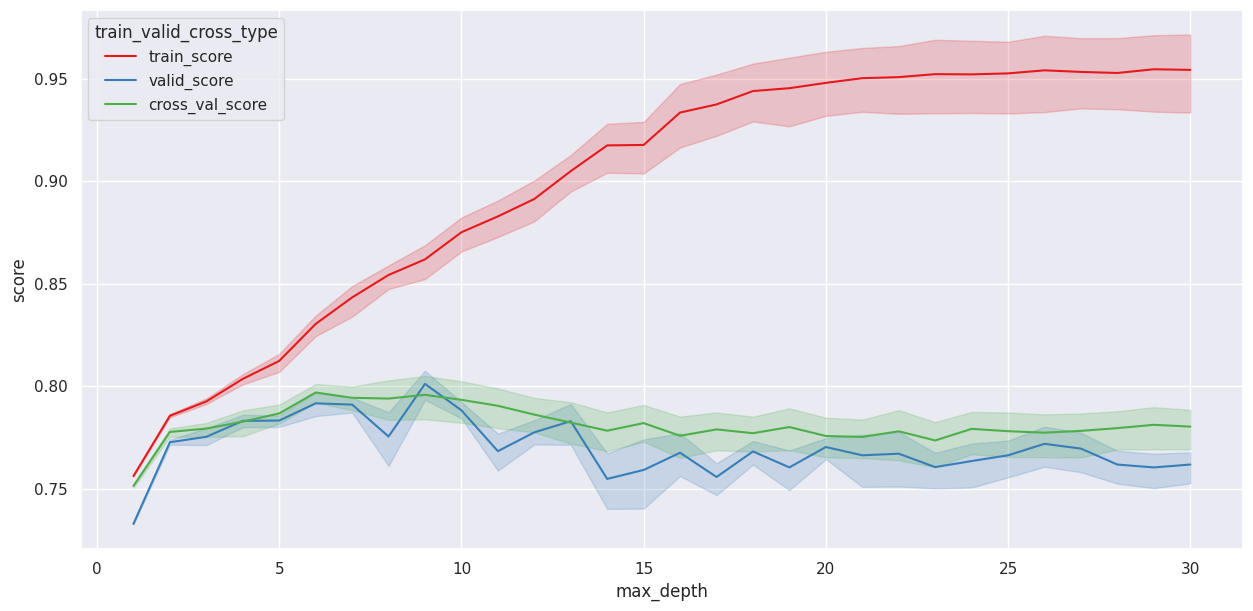

In [31]:
# визуализируем полученные данные значений accuracy для тренировочной
# и валидационной выборки и для accuracy по кроссвалидации
sns.lineplot(data = scores_model_2,
    x = 'max_depth',
    y = 'score',
    hue = 'train_valid_cross_type',
    palette = 'Set1')

sns.set(rc={'figure.figsize': (15, 7)})

plt.show()

Второй график, отображающий динамику accuracy, построим для параметра x = 'n_estimators'

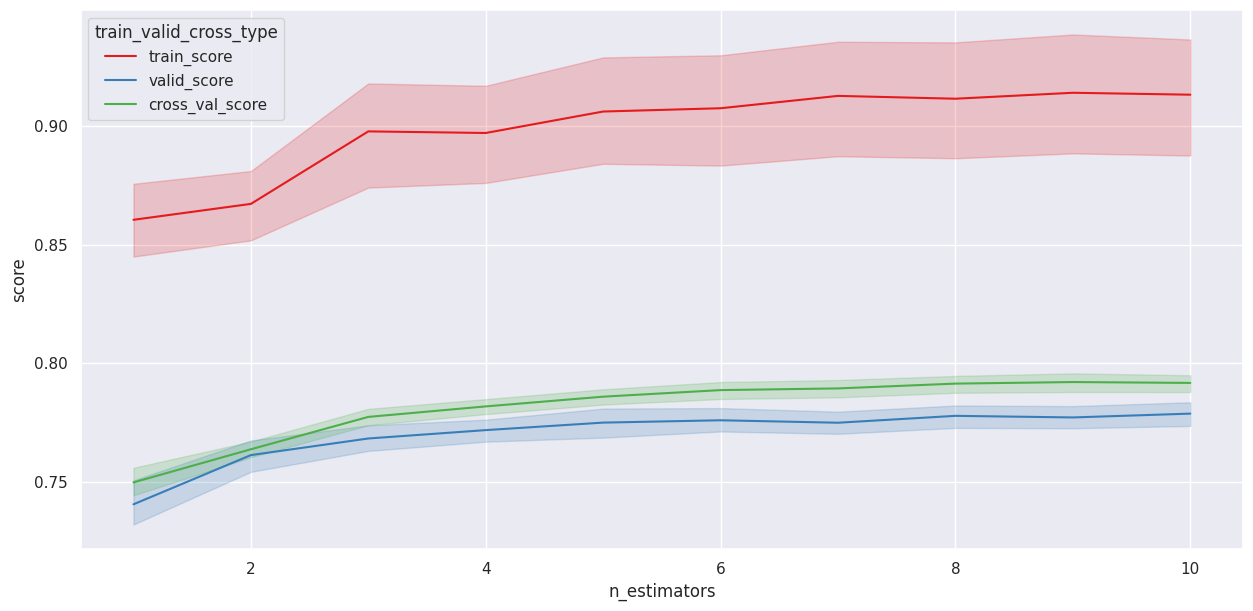

In [32]:
# визуализируем полученные данные значений accuracy для тренировочной
# и валидационной выборки и для accuracy по кроссвалидации
sns.lineplot(data = scores_model_2,
    x = 'n_estimators',
    y = 'score',
    hue = 'train_valid_cross_type',
    palette = 'Set1')

sns.set(rc={'figure.figsize': (15, 7)})

plt.show()

Конечно, выводы, сделанные на основе графиков с разным параметром x несколько уязвимы. Однако, общая тенденция просматривается достаточно хорошо: для графика, построенного по x = 'max_depth' лишь на коротком отрезке примерно  на значениях (7, 8) accuracy по валидационной выборке превышает accuracy по кроссвалидации. Для графика, построенного по x = 'n_estimators' для всех значений n_estimators accuracy по кроссвалидации превышает accuracy по валидационной выборке.

Еще один важный вывод следует из двух рисунков - нельзя заключить, что достигнут лучший уровень обученности моделей. Accuracy по валидационной выборке и по кроссвалидации не стремятся резко вниз, как на рисунке в п. 3.1.1. Переобучение модели в п. 3.1.1  наступило значительно раньше. По полученным результатам мы не можем сказать, что потенциал обучения модели исчерпан. Как вариант, можно было бы увеличить вариационное значение двух гиперпарамтеров 'max_depth' и 'n_estimators', это еще увеличило бы время обучения, но могло бы позволить достичь более высокий уровень accuracy. Не будем этого делать по трем причинам:

   **(1)** изменение гиперпараметров и новое обучение модели потребует обнулись большую часть текущего пп. 3.2.1 и подготовить его заново
   
   **(2)** модель, удовлетворяющая установленному пороговому уровню accuracy >= 0.75 успешно получена
   
   **(3)** в п. 3.2.2 лучшая модель классификации случайного леса будет выявлена с помощью GridSearchCV при использовании большего числа гиперпараметров, и независимо от того, каким будет accuracy этой модели, уже в этой точке выполнения исследования есть уверенность, что в любом случае получена удовлетворяющая требованиям модель классификации случайного леса

**Вывод по 3.2.1**:

**(1)** наилучшее значение accuracy = 0.8096 для модели классификации случайного леса достигнуто при гиперпараметрах criterion='entropy', max_depth=9, n_estimators=9, random_state=14

**(2)** учебному заданию, согласно которому accuracy >= 0.75 модель соответствует. Модель сохранена в переменную **best_model_2**

#### **3.2.2 Поиск лучшей модели классификации случайного леса с помощью GridSearchCV**

Проведем инвентаризацию гиперпараметров, котоыре будут 'принимать участие' в определении лучшей модели классификации случайного леса с помощью GridSearchCV:

   1 - 'criterion' = 'entropy'
   
   2 - 'max_depth' = range(1, 31)
   
   3 - 'max_features' = range(1, 6)
   
   4 - 'min_samples_split' = range(1, 11)
   
   5 - 'min_samples_leaf' = range(1, 6)
   
   6 - 'n_estimators' = range(1, 11)
   
в качестве базового критерия при объявлении объекта GridSearchCV будет указан scoring = accuracy. Также при объявлении объекта GridSearchCV будет укзаан параметр 'n_jobs'

In [33]:
# объявим модель классификации случайного леса
model_best_2 = RandomForestClassifier(random_state = 14)

In [34]:
# создаем словарь с гиперпараметрами и варьируемыми значениями
params_model_best_2 = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31, 3),
    'max_features': range(1, 6),
    'min_samples_split': range(1, 11, 3),
    'min_samples_leaf': range(1, 6),
    'n_estimators': range(1, 11, 3),
    }

In [35]:
%%time

# объявляем объект GridSearchCV
grid_model_best_2 = GridSearchCV(
    model_best_2,
    params_model_best_2,
    cv = 5,
    scoring = 'accuracy',
    n_jobs= -1)

# обучаем модель с помощью функции fit()
grid_model_best_2.fit(train_features, train_target)

CPU times: user 11.5 s, sys: 798 ms, total: 12.2 s
Wall time: 5min 12s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=14), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31, 3),
                         'max_features': range(1, 6),
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(1, 11, 3),
                         'n_estimators': range(1, 11, 3)},
             scoring='accuracy')

In [36]:
# сохраним модель RandomForestClassifier, полученную с помощью
# GreedSearchCV, в переменную best_forest_model
best_forest_model = grid_model_best_2.best_estimator_
best_forest_model

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=2,
                       min_samples_leaf=2, min_samples_split=7, n_estimators=7,
                       random_state=14)

Посчитаем accuracy. Значение accuracy в GridSearchCV определяется с помощью кроссвалидации. В пп. 3.2.1 лучшее значение также было взято по кроссвалидации, обучающие выборки совпадают, поэтому сравнение показателя будет корректным

In [37]:
# вычислим accuracy по кроссвалидации модели с лучшими параметрами
grid_model_best_2.best_score_

0.8137985330731444

Лучшее значение accuracy, определенное только по перебору в цикле двух параметров ('max_depth' и 'n_estimators') было равно 0.8096, время обучения модели составило 4 мин. 53 секунды. Применение GreedSearchCV и поиск модели с лучшими характеристиками уже по пяти вариативным параметрам (шестой параметр 'criterion' был задан единственным значением 'entropy') позволили получить accuracy немного выше, чем у предыдущих моделей, но потребовало значительного времени обучения модели. Едва ли имеет смысл проводить подбор параметров по расширенной гамме и указывать для перебора такое большое количество вариативных значений.


В любом случае получена модель, имеющая лучшие параметры обученности, чем та, которую выявили с помощью применения цикла

In [38]:
# еще раз посмотрим на выявленные с помощью GridSearchCV
# лучшие значения гиперпараметров
grid_model_best_2.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 7}

**Вывод по 3.2.2**:

**(1)** наилучшее значение accuracy = 0.8143 для модели классификации случайного леса выявлено с помощью GridSearchCV при гиперпараметрах:

    - 'criterion': entopy
    - 'max_depth': 10
    - 'max_features': 2
    - 'min_samples_leaf': 1
    - 'min_samples_split': 3
    - 'n_estimator': 9
    
**(2)** учебному заданию, согласно которому accuracy >= 0.75 модель соответствует. Модель сохранена в переменную **best_forest_model**

**Вывод по 3.2 Модель классификации случайного леса (RandomForestClassifier)**:

**(1)** был проведен анализ, в результате которого выявлена модель RandomForestClassifier с наибольшим уровнем accuracy. Модель была определена с помощью GridSearchCV и при значениях гиперпараметров:

   'criterion' = 'entropy', 'max_depth' = 10, 'max_features' = 2, 'min_samples_leaf' = 1, 'min_samples_split' = 3, 'n_estimator' = 9
   
показала уровень accuracy = 0.8137

**(2)** Модель с лучшими параметрами сохранена в переменную **best_forest_model**

### **3.3 Модель логистической регрессии (LogisticRegression)**

Для логистической регрессии лучшая модель будет выбрана только с помощью GridSearchCV по выделенной во 2-м разделе обучающей выборке.

При объявлении объекта GridSearchCV укажем следующие параметры:

   **(1)** - verbose = 3 (заданный любым положительным числом этот параметр определяет детализацию)

   **(2)** - cv = 5 (количество частей (fold), на которые будет разделена обучающая выборка при кросвалидации)

Для модели логистической регрессии будет установлено **два гиперпараметра**:

**(1)** - **'solver'** = 'lbfgs' – параметр устанавливает алгоритм, используемый в задаче оптимизации. Для многоклассовых задач и в качестве алгоритма по умолчанию используется 'lbfgs'. В порядке эксперимента и с учетом того, что обучение модели логистической регрессии идет гораздо быстрее моделей классификации деревом решений и модели классификации случайного леса проверим все доступные параметры: 'solver' = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
   
**(2)** - **'max_iter'** = range(100, 1000, 100) – параметр устанавливает количество итераций, выполняемых при обучении модели

In [39]:
# объявим модель логистической регрессии
model_best_3 = LogisticRegression(random_state = 14)

In [40]:
# создаем словарь с гиперпараметрами и варьируемыми значениями
params_model_best_3 = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': range(100, 10001, 100)
    }

In [41]:
%%time

# объявляем объект GridSearchCV,

grid_model_best_3 = GridSearchCV(
    model_best_3,
    params_model_best_3,
    cv = 5,
    scoring = 'accuracy',
    n_jobs= -1)

# обучаем модель с помощью функции fit()
grid_model_best_3.fit(train_features, train_target)

CPU times: user 5.8 s, sys: 670 ms, total: 6.47 s
Wall time: 6min 2s


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=14), n_jobs=-1,
             param_grid={'max_iter': range(100, 10001, 100),
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [42]:
# сохраним лучшую модель LogisticRegression, полученную с помощью
# GreedSearchCV, в переменную best_forest_model
best_logistic_model = grid_model_best_3.best_estimator_
best_logistic_model

LogisticRegression(random_state=14, solver='newton-cg')

In [43]:
# вычислим accuracy по кроссвалидации модели логистической регрессии
# с лучшими параметрами
grid_model_best_3.best_score_

0.7536343449296817

In [44]:
# еще раз посмотрим на выявленные с помощью GridSearchCV
# лучшие значения гиперпараметров
grid_model_best_3.best_params_

{'max_iter': 100, 'solver': 'newton-cg'}

**Вывод по 3.3 Модель логистической регрессии (LogisticRegression)**:

**(1)** был проведен анализ, в результате которого выявлена модель LogisticRegression с наибольшим уровнем accuracy. Модель была определена с помощью GridSearchCV и при значениях гиперпараметров:

   'solver' = 'newton-cg', 'max_iter' = 100
   
показала уровень accuracy = 0.7536

**(2)** учебному заданию, согласно которому accuracy >= 0.75, модель соответствует. Модель с лучшими параметрами сохранена в переменную **best_logistic_model**

**Вывод по 3 Исследуйте модели**

Построим сводную таблицу, отражающую результаты эксперимента по обучению моделей

In [45]:
experiments_result = pd.DataFrame(
    {'Модель': ['Дерево (цикл for) - best_model_1',
               'Дерево (GridSearchCV) - best_tree_model',
               'Лес (цикл for) - best_model_2',
               'Лес (GridSearchCV) - best_forest_model',
               'Логистич. регрессия (GridSearhCV) - best_logistic_model'],
    'accuracy': [0.7977, 0.8070, 0.8096, 0.8137, 0.7536]
    }
)

experiments_result

,Модель,accuracy
0,Дерево (цикл for) - best_model_1,0.7977
1,Дерево (GridSearchCV) - best_tree_model,0.8070
2,Лес (цикл for) - best_model_2,0.8096
3,Лес (GridSearchCV) - best_forest_model,0.8137
4,Логистич. регрессия (GridSearhCV) - best_logis...,0.7536


Несмотря на огромные затраты на обучение лидером по accuracy стала модель классификации случайного леса **best_forest_model**. На втором месте тоже модель классификации случайного леса, но выявленная с помощью цикла for (**best_model_2**). Разрыв по accuracy чрезвычайно мал, - чтобы его достигнуть, потребовалось увеличить длительность обучения в десятки раз. Причина – для модели-лидера было взято целых пять варьируемых параметров, и если бы поиск модели с помощью цикла был также проведен по пяти параметрам, скорее всего длительность для модели, выбранной циклом, была бы значительно выше. Проведение эксперимента о том, как быстро удастся выявить лучшую модель с помощью цикла for и с помощью GridSearchCV **при одинаковом числе варьируемых гиперпарамтеров**, не входило в задачи исследования, поэтому такая оценка не проводилась.

Преждевременно делать вывод о том, что GridSearchCV значительно уступает циклу for по скорости выявления лучшей модели. GridSearchCV является более 'продвинутым' способом’, и скорее всего при равных условиях покажет гораздо более высокий результат по скорости.

3-е и 4-е место получили модели классификации деревом решении. Более высокий уровень accuracy показала модель, выявленная с помощью GridSearchCV, но это также было достигнуто за счет более длительного обучения и большего количества гиперпараметров с варьируемыми значениями.

Самый низкий результат по accuracy показала модель логистической регрессии, которая неплохо показала себя с точки зрения временных затрат и проверила два гиперпараметра с варьируемыми значениями.

**Для итоговой проверки на тестовой выборке отобрана модель классификации случайного леса best_forest_model, отобранная с помощью GridSearchCV**.

## Проверка модели на тестовой выборке

Проверим качество модели best_forest_model на тестовой выборке, для этого получим предсказания на тестовой выборке с признаками и следом вычислим accuracy_score

In [46]:
# получаем предсказания лучшей модели по тестовой выборке
test_predictions = best_forest_model.predict(test_features)

# рассчитываем accurasy лучшей модели по тетсовой выборке
test_accuracy = round(accuracy_score(test_target, test_predictions), 4)

print('accuracy лучшей модели на тестовой выборке:', test_accuracy)

accuracy лучшей модели на тестовой выборке: 0.8087


In [47]:
# рассчитаем метрику precision лучшей модели
test_precision = round(precision_score(test_target, test_predictions), 4)

# рассчитаем метрику recall лучшей модели
test_recall = round(recall_score(test_target, test_predictions), 4)

# рассчитаем метрику f1_score лучшей модели
test_f1_score = round(f1_score(test_target, test_predictions), 4)

print('precision лучшей модели на тестовой выборке:', test_precision)
print('recall лучшей модели на тестовой выборке:', test_recall)
print('f1_score лучшей модели на тестовой выборке:', test_f1_score)

precision лучшей модели на тестовой выборке: 0.7681
recall лучшей модели на тестовой выборке: 0.5381
f1_score лучшей модели на тестовой выборке: 0.6328


**Вывод по 4 Проверьте модель на тестовой выборке**:

**(1)** лучшая из пяти выявленных моделей **best_forest_model** показала уровень accuracy равный 0.8087, соответствующий установленному пороговому уровню >= 0.75

**(2)** в сравнении с оценкой accuracy по кроссвлаидации по обучающей выборке тестовый уровень accuracy понизился незначительно, следовательно, модель не является переобученной.

**(3)** метрика precision = 0.7681 лучшей модели best_forest_model достаточна для того, чтобы считать результат хорошим: ложные срабатывания есть, но их не очень много. Метрика recall = 0.5381 отражает насколько удается найти все положительные примеры, и в этой части выбранная нами модель показывает себя не лучшим образом, значение recall оказалось невысоким. Метрика f_score = 0.6328 объединяет информацию о точности (precision) и полноте (recall), и, как мы видим, суммарная характеристика лучшей модели не очень высокая по причине низкого значения recall, но это максимум, что можно получить при исходных данных датасета.

## Проверка модели на адекватность

Чтобы проверить лучшую модель best_forest_model на адекватность обучим модель  DummyClassifier на тренировочной выборке и посчитаем accuracy на тестовой и сопоставим результаты accuracy на тестовой выборке лучшей модели и модели DummyClassifier

In [48]:
# объявляем модель DummyClassifier
dummy_test = DummyClassifier(
    strategy = 'most_frequent',
    random_state = 14
)

In [49]:
# обучаем модель dummy_test на обучающей выборке
dummy_test.fit(train_features, train_target)

DummyClassifier(random_state=14, strategy='most_frequent')

In [50]:
# получаем предсказание модели dummy_classifier на тестовой выборке
dummy_test_predictions = dummy_test.predict(test_features)

In [51]:
# вычислим accuracy модели dummy_classifier по тестовой выборке
dummy_test_accuracy = round(accuracy_score(test_target,
                            dummy_test_predictions), 4)

print('accuracy модели dummy_test на тестовой выборке:', dummy_test_accuracy)

accuracy модели dummy_test на тестовой выборке: 0.6936


**Вывод по 5 Проверка модели на адекватность**:

**(1)** accuracy лучшей из пяти выявленных моделей **best_forest_model**  равна 0.8087, accuracy модели dummy_test ('глупой' модели) равен 0.6936. Лучшая из выявленных моделей успешно прошла проверку и показала более высокий уровень в сравнении с моделью, игнорирующей признаки объекта.

## ИТОГОВЫЕ ВЫВОДЫ ПО ПРОЕКТУ

**(1)** для выполнения поставленной цели, - на основе данных о поведении клиентов оператора мобильной связи 'Мегалайн', уже перешедших на новые тарифы 'Smart' и 'Ultra', построить модель для классификации пользователей в зависимости от используемого ими тарифа с максимально большим значением accuracy, - полученные данные были предварительно изучены, разделены на обучающую (60%), валидационную (20%) и тестовую (20%) выборки с учетом стратификации (было обеспечено равномерное распределение признаков классов).

**(2)** для решения задачи классификации были обучены следующие модели:

   - модель классификации деревом решений (DecisionTreeClassifier)

   - модель классификации случайного леса (RandomForestClassifier)

   - модель логистической регрессии (LogisticRegression)

Была проведена серия экспериментов по обучению моделей с разным количеством гиперпараметров и количеством варьируемых значений гиперпараметров. Результаты серии экспериментов отражены в сводной таблице

In [52]:
experiments_result

,Модель,accuracy
0,Дерево (цикл for) - best_model_1,0.7977
1,Дерево (GridSearchCV) - best_tree_model,0.8070
2,Лес (цикл for) - best_model_2,0.8096
3,Лес (GridSearchCV) - best_forest_model,0.8137
4,Логистич. регрессия (GridSearhCV) - best_logis...,0.7536



**(3)** по итогам испытания на тестовой выборке лучшая модель показала следующие результаты:

- acuracy: 0.8087

- precision: 0.7681

- recall: 0.5381

- f1_score: 0.6328

**(5)** проверку на вменяемость (адекватность) модель прошла успешно, поэтому модель best_forest_model **рекомендуется к практическому применению для предсказания предпочтений абонентов, использующих архивные тарифы**